# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [74]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [3]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

## load data

In [3]:
import os
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata

def load_and_merge_data_v3(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count = 0
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # pandasでTSVファイルを読み込み
            if count == 0:
                adata=sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata.X)
                adata.X = sparse_X
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
            else:
                adata_append = sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata_append.X)
                adata_append.X = sparse_X
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
            
                # 連結
                adata = anndata.concat([adata, adata_append])
                print(adata.X.shape)
            
            count += 1
            
    return adata

base_dir = '/temp/data/human_Sz_PFC_each'
#adata = load_and_merge_data_v3(base_dir)
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
#adata.write(file_path)

In [4]:
base_dir = '/temp/data/human_Sz_PFC_each'
#adata = load_and_merge_data_v3(base_dir)
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
adata = anndata.read_h5ad(file_path)
print(adata.X.shape)

(203786, 60617)


In [5]:
var_names=adata.var_names

In [7]:
df_var_name=pd.DataFrame(var_names)
df_var_name.to_csv("/temp/data/human_Sz_PFC_each/var_name.csv")

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

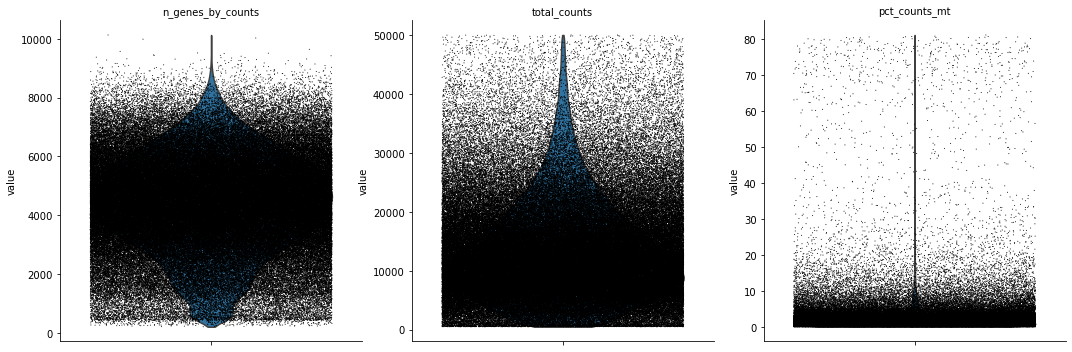

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
adata.var['mt']

WASH7P         False
MIR1302-2HG    False
AL627309.1     False
CICP27         False
AL627309.6     False
               ...  
AC004556.1     False
AC240274.1     False
RF00003.15     False
AC213203.2     False
AC213203.1     False
Name: mt, Length: 42699, dtype: bool

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata_scanpy_ana.h5ad"
adata.write(file_path)

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

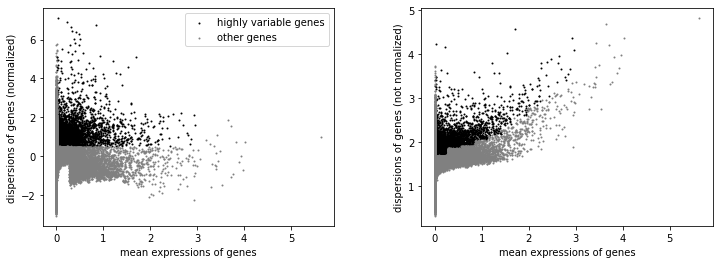

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
n_neighbors=10
knn_n_pcs=40
umap_min_dist=0.3
umap_spread=1.0


sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs,
                    method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread,
               method='rapids')
sc.tl.louvain(adata, flavor='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [24]:
sc.tl.umap(adata)

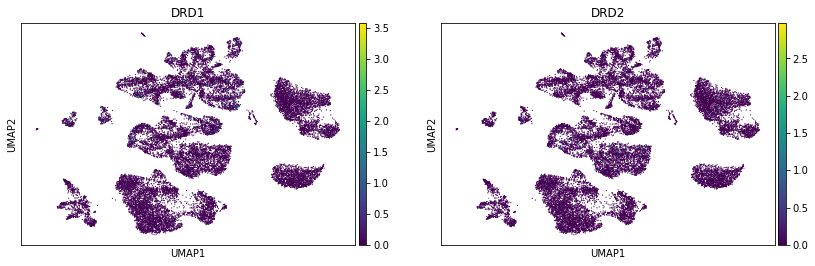

In [28]:
sc.pl.umap(adata, color=['DRD1','DRD2'])

In [29]:
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

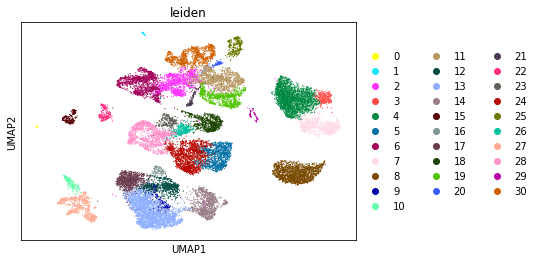

In [75]:
sc.pl.umap(adata, color=["leiden"])

In [68]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

In [70]:
params

{'USE_FIRST_N_CELLS': 300000,
 'MITO_GENE_PREFIX': 'mt-',
 'markers': ['CX3CR1',
  'CLDN5',
  'GLUL',
  'NDRG2',
  'PCDH15',
  'PLP1',
  'MBP',
  'SATB2',
  'SLC17A7',
  'SLC17A6',
  'GAD2',
  'GAD1',
  'SNAP25',
  'HTR1A',
  'HTR1B',
  'HTR1D',
  'HTR1E',
  'HTR2A',
  'HTR2B',
  'HTR2C',
  'HTR3A',
  'HTR4',
  'HTR5A',
  'HTR6',
  'HTR7',
  'DRD1',
  'DRD2',
  'DRD3',
  'DRD4',
  'DRD5',
  'HRH1',
  'HRH2',
  'HRH3',
  'CHRM1',
  'CHRM2',
  'CHRM3',
  'CHRM4',
  'CHRM5',
  'ADRA1A',
  'ADRA1B',
  'ADRA2A',
  'ADRA2B',
  'ADRA2C',
  'ADRB1',
  'ADRB2'],
 'min_genes_per_cell': 200,
 'max_genes_per_cell': 6000,
 'min_cells_per_gene': 1,
 'n_top_genes': 4000,
 'n_components': 50,
 'pca_train_ratio': 0.35,
 'n_pca_batches': 10,
 'tsne_n_pcs': 20,
 'k': 35,
 'n_neighbors': 15,
 'knn_n_pcs': 50,
 'umap_min_dist': 0.3,
 'umap_spread': 1.0}

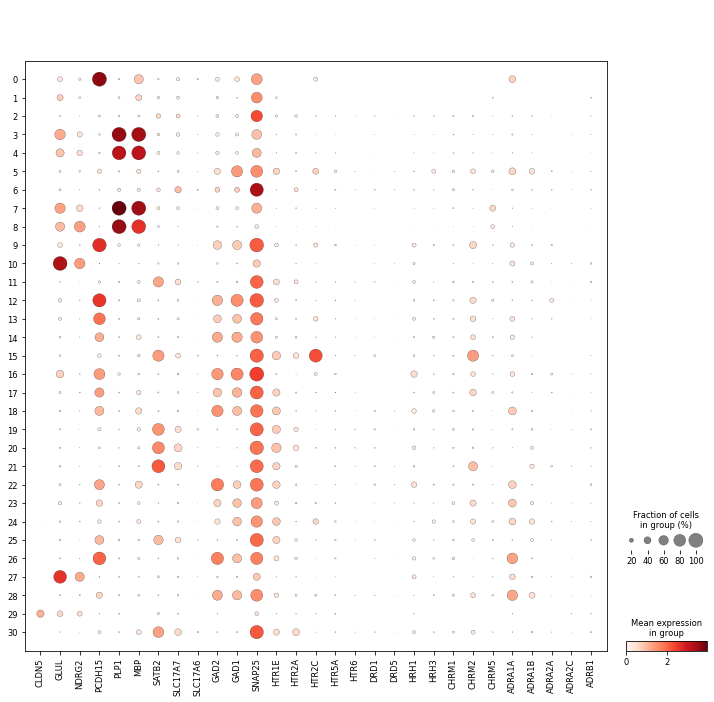

In [72]:
# データセット内で存在するマーカージーンのみをフィルタリング
existing_markers = [gene for gene in params["markers"] if gene in adata.var_names]

# フィルタリング後のマーカージーンリストを使用してdotplotを実行
sc.pl.dotplot(adata, existing_markers, groupby='leiden')

In [31]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata_scanpy_ana.h5ad"
adata.write(file_path)

In [33]:
adata.obs['condition'] 

MB11_AAACCCAGTAGCACGA.1           control
MB11_AAACGAACAGGAATCG.1           control
MB11_AAACGAATCGGCTTGG.1           control
MB11_AAACGCTAGACCTCCG.1           control
MB11_AAACGCTAGAGAGGTA.1           control
                                ...      
MB8.2_TGGCGTGCACTATCCC.1    schizophrenia
MB8.2_TGGGAAGCAAAGGGCT.1    schizophrenia
MB8.2_TGTGGCGCATGAGATA.1    schizophrenia
MB8.2_TGTGGCGGTATGGAGC.1    schizophrenia
MB8.2_TTTACTGTCTGTGCAA.1    schizophrenia
Name: condition, Length: 21881, dtype: category
Categories (2, object): ['control', 'schizophrenia']

In [50]:
clusters = adata.obs['leiden'].cat.categories

for cluster in clusters:
    # クラスタのサブセットを取得
    subset = adata[adata.obs['leiden'] == cluster]
    
    # クラスタ内で2つ以上のconditionカテゴリが存在するかチェック
    if len(subset.obs['condition'].cat.categories) > 1:
        # そのサブセット内でconditionに基づいてDEGを計算
        sc.tl.rank_genes_groups(subset, groupby='condition', method='t-test', key_added=f'rank_genes_{cluster}')
        #sc.tl.rank_genes_groups(subset, groupby='condition', method='wilcoxon', key_added=f'rank_genes_{cluster}')
        
        # 結果を元のadataオブジェクトに保存
        adata.uns[f'rank_genes_{cluster}'] = subset.uns[f'rank_genes_{cluster}']
    else:
        print(f"Cluster {cluster} has only one condition category. Skipping DEG calculation.")

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Cluster 3 has only one condition category. Skipping DEG calculation.


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Cluster 9 has only one condition category. Skipping DEG calculation.
Cluster 10 has only one condition category. Skipping DEG calculation.


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Cluster 16 has only one condition category. Skipping DEG calculation.


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [62]:
def plot_volcano(adata, cluster, key='rank_genes'):
    if f'{key}_{cluster}' not in adata.uns:
        print(f"No data found for cluster {cluster}. Skipping...")
        return
    
    gene_names = adata.uns[f'{key}_{cluster}']['names']
    logfoldchanges = adata.uns[f'{key}_{cluster}']['logfoldchanges']['schizophrenia']
    pvals_adj = adata.uns[f'{key}_{cluster}']['pvals_adj']['schizophrenia']
    
    # 欠損値の確認と取り扱い
    if np.any(np.isnan(pvals_adj)):
        print(f"Found NaN values in pvals_adj for cluster {cluster}. Replacing with 1.")
        pvals_adj[np.isnan(pvals_adj)] = 1.0

    plt.figure(figsize=(10, 5))
    plt.scatter(logfoldchanges, -np.log10(pvals_adj), color='gray')

    # 調整後のp値のしきい値（例：0.05）より小さいDEGsをハイライト
    plt.scatter(logfoldchanges[pvals_adj < 0.05], -np.log10(pvals_adj[pvals_adj < 0.05]), color='red')
    
    plt.title(f"Volcano Plot for Cluster {cluster}")
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10(Adjusted P-value)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
    plt.show()

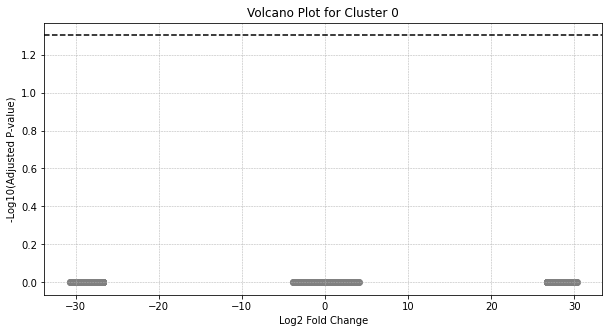

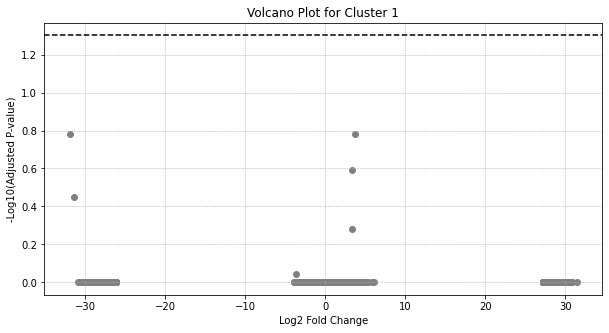

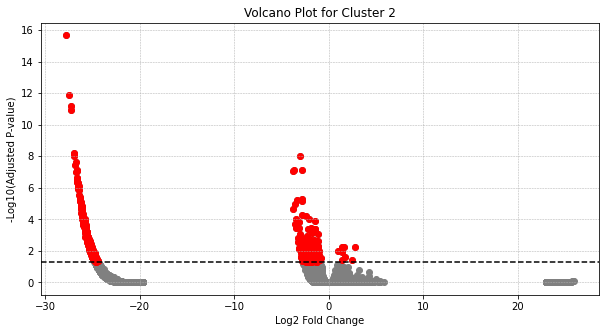

No data found for cluster 3. Skipping...


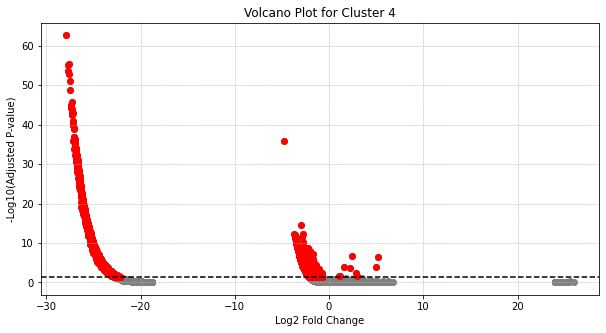

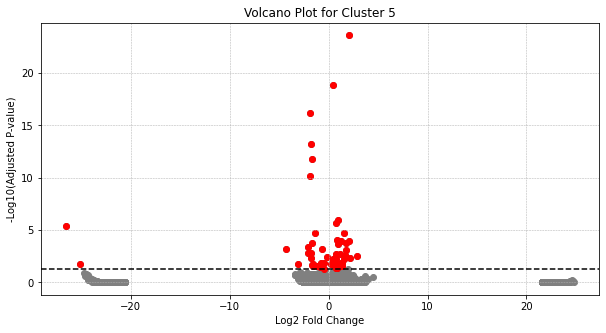

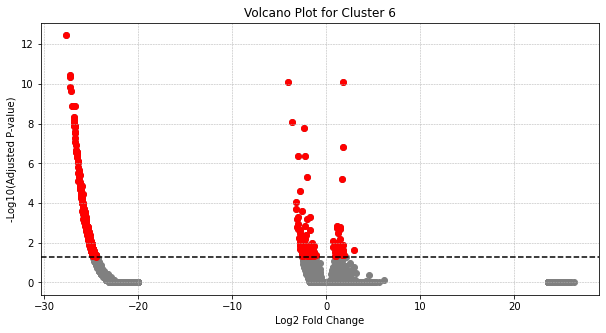

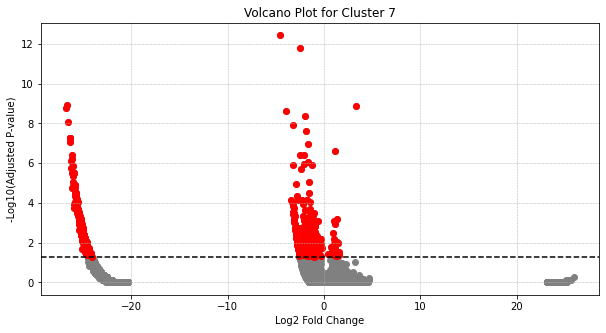

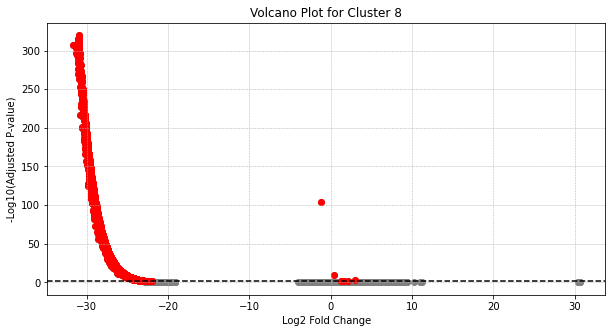

No data found for cluster 9. Skipping...
No data found for cluster 10. Skipping...


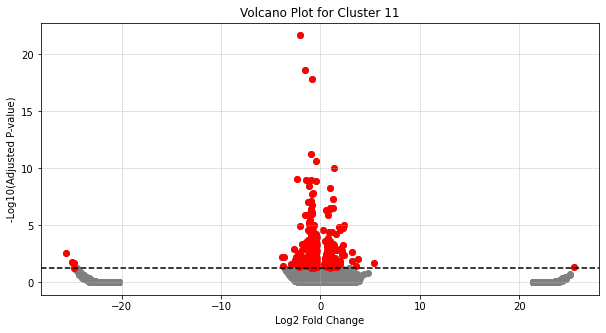

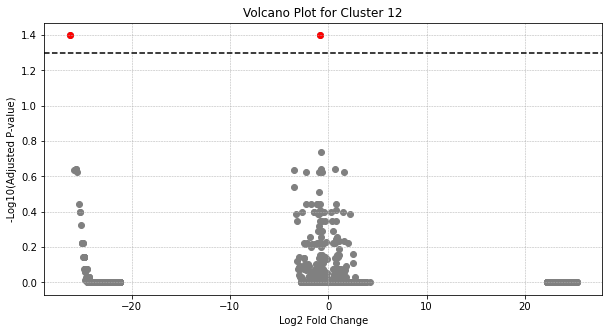

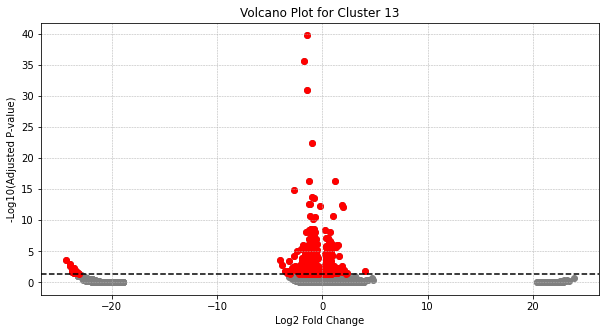

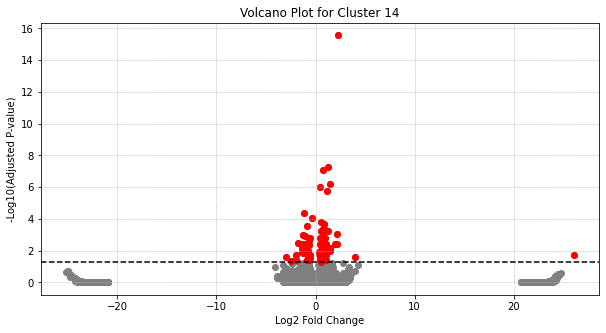

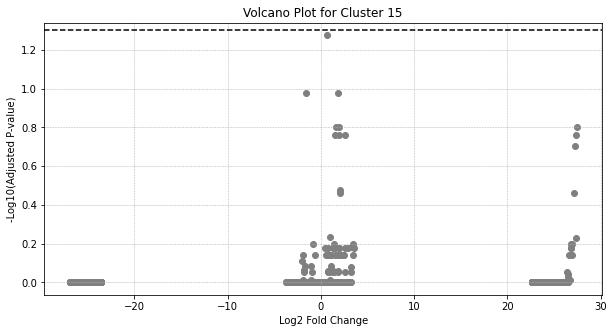

No data found for cluster 16. Skipping...


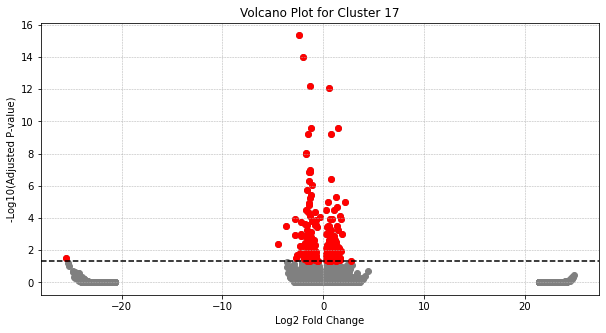

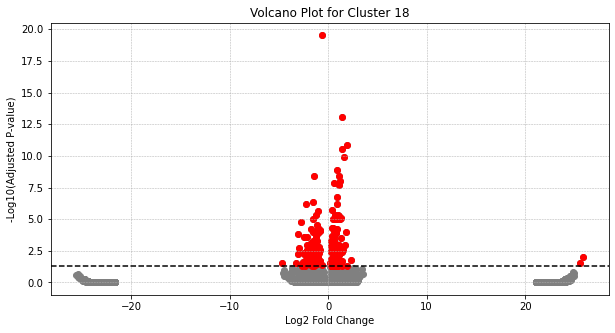

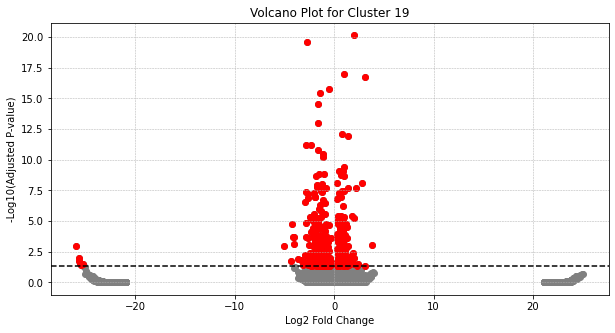

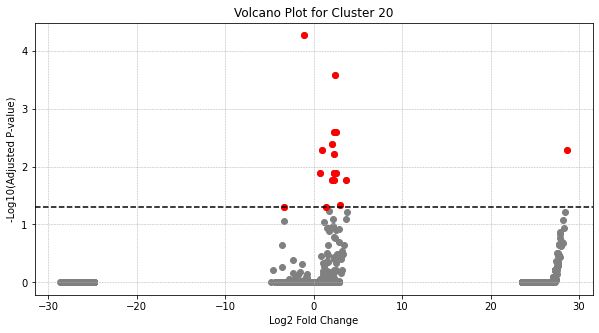

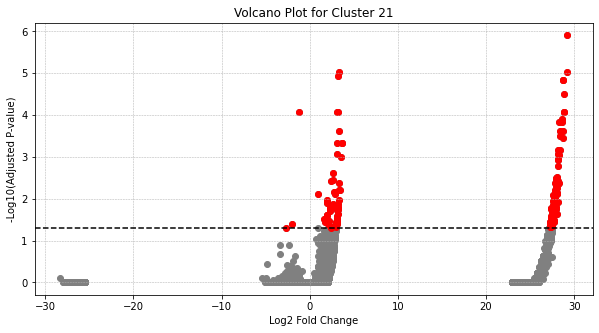

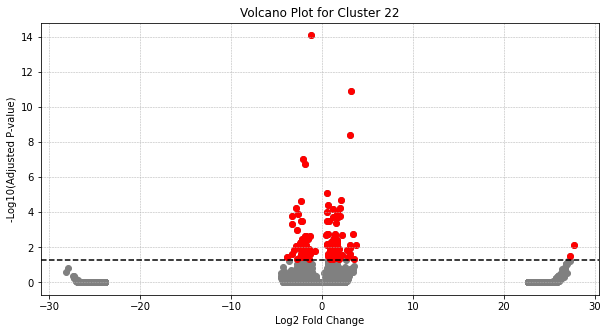

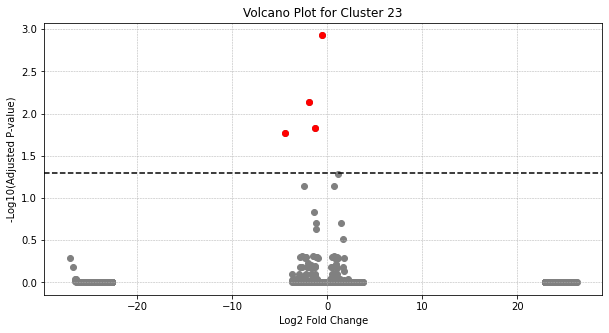

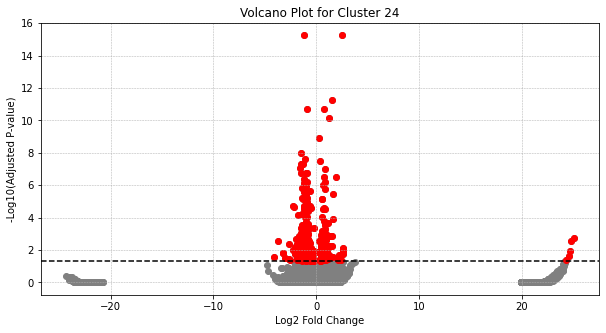

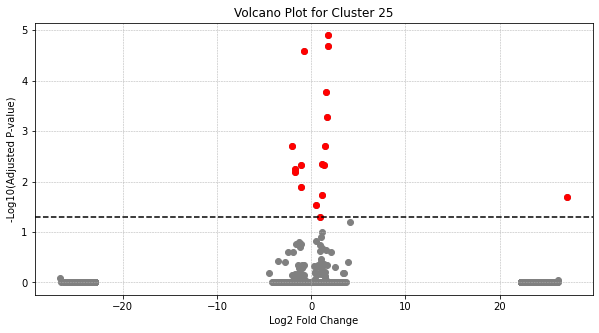

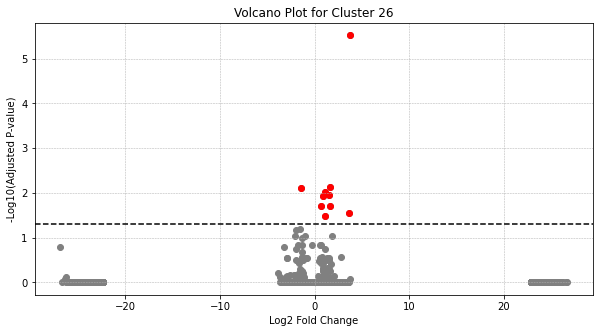

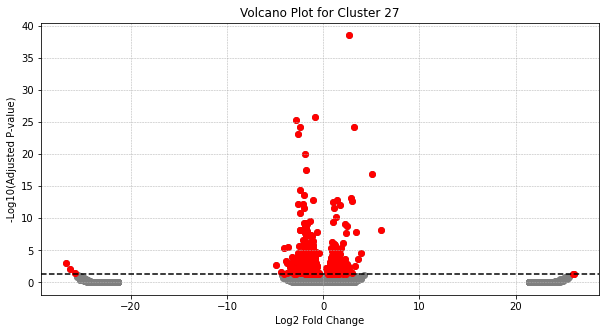

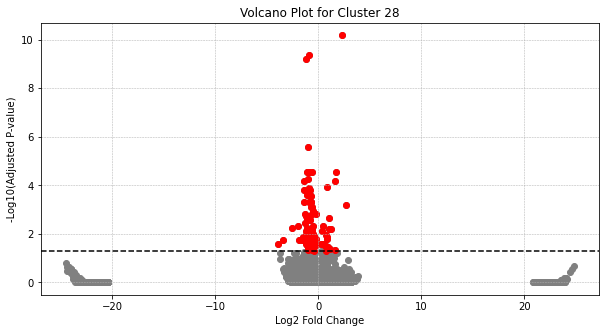

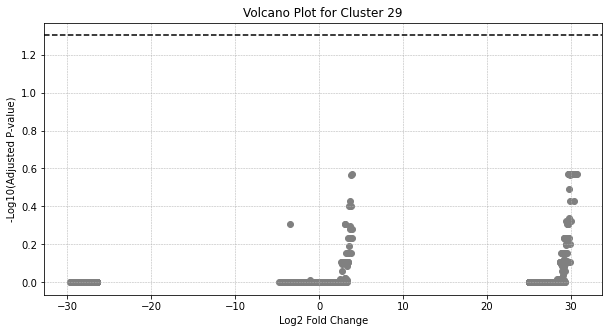

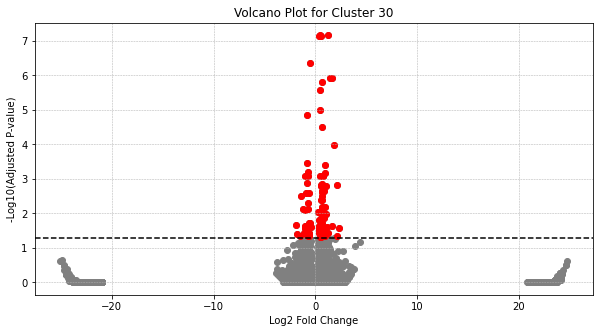

In [63]:
clusters = adata.obs['leiden'].cat.categories
for cluster in clusters:
    plot_volcano(adata, cluster)

In [64]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata_scanpy_ana.h5ad"
adata.write(file_path)

In [66]:

def save_deg_to_csv(adata, cluster, save_dir='.', key='rank_genes', threshold=0.05):
    # クラスターに対するDEGデータを取得
    gene_names = adata.uns[f'{key}_{cluster}']['names']
    logfoldchanges = adata.uns[f'{key}_{cluster}']['logfoldchanges']
    pvals_adj = adata.uns[f'{key}_{cluster}']['pvals_adj']['schizophrenia']
    
    # DEGデータをpandas DataFrameに変換
    df = pd.DataFrame({
        'Gene_Name': gene_names,
        'Log2_FoldChange': logfoldchanges,
        'Adjusted_P-value': pvals_adj
    })

    # 調整後のp値がしきい値より小さいものだけをフィルタリング
    significant_degs = df[df['Adjusted_P-value'] < threshold]

    # 保存ディレクトリが存在しない場合は作成
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # CSVファイルに保存
    filename = os.path.join(save_dir, f'cluster_{cluster}_DEGs.csv')
    significant_degs.to_csv(filename, index=False)
    print(f"Saved DEGs for cluster {cluster} to {filename}.")

clusters = adata.obs['leiden'].cat.categories
save_directory = '/temp/data/human_Sz_PFC_each/DEG_csv'  # この行で望むディレクトリを指定してください
for cluster in clusters:
    if f'rank_genes_{cluster}' in adata.uns:
        save_deg_to_csv(adata, cluster, save_dir=save_directory)

Saved DEGs for cluster 0 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_0_DEGs.csv.
Saved DEGs for cluster 1 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_1_DEGs.csv.
Saved DEGs for cluster 2 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_2_DEGs.csv.
Saved DEGs for cluster 4 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_4_DEGs.csv.
Saved DEGs for cluster 5 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_5_DEGs.csv.
Saved DEGs for cluster 6 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_6_DEGs.csv.
Saved DEGs for cluster 7 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_7_DEGs.csv.
Saved DEGs for cluster 8 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_8_DEGs.csv.
Saved DEGs for cluster 11 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_11_DEGs.csv.
Saved DEGs for cluster 12 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_12_DEGs.csv.
Saved DEGs for cluster 13 to /temp/data/human_Sz_PFC_each/DEG_csv/cluster_13_DEGs.csv.
Saved DEGs for cluster 14 to /temp/data/human_Sz_PFC_each/D

In [4]:
D_R_mtx=pd.read_csv("/temp/drug_receptor_mtx.csv",index_col=0)
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

drug_list=D_R_mtx.index.to_list()
GPCR_list=["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]
D_R_mtx.columns=GPCR_list

In [5]:
# maximum number of cells to load from files
USE_FIRST_N_CELLS = 300000

# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization
#print(d_r_column_rep[1:])
markers.extend(GPCR_list)
markers = [str.upper() for str in markers]

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [ ]:
preprocess_start = time.time()

In [6]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
sparse_gpu_array, genes, marker_genes_raw = \
    rapids_scanpy_funcs.preprocess_in_batches(file_path, 
                                              markers, 
                                              min_genes_per_cell=min_genes_per_cell, 
                                              max_genes_per_cell=max_genes_per_cell, 
                                              min_cells_per_gene=min_cells_per_gene, 
                                              target_sum=1e4, 
                                              n_top_genes=n_top_genes,
                                              max_cells=USE_FIRST_N_CELLS)

Calculating data size.
Filtering cells
Identifying genes to filter
Filtering genes and normalizing data
Calculating highly variable genes.
Storing raw marker gene expression.
Filtering highly variable genes.


In [ ]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
adata_processed=ct.preprocess_adata(file_path)